## Colors of Central Cluster Galaxies
#### Compiled by Michael Wood-Vasey, based on work by Eli Rykoff and Dominique Boutigny
#### Last Verified to run: 2019-07-23

Do the measured extended magnitudes of central cluster galaxies make sense, and do they agree with the truth catalog?

A validation Notebook based on Eli Rykoff's cModelFlux investigation of colors of central cluster galaxies.  He found that the g-r colors were off at all redshifts, while the r-i and i-z colors were progressively better.  There was also a significant increased scatter in colors (~0.1-0.5 mag) not explained by the SNR.

The status as of the DESC Paris Collaboration Meeting (Jul 15-19, 2019) was "No".

This Notebook focuses on central (halo)cluster galaxies because they should follow a well-defined red sequence, but the issues identified likely affect all galaxies.

The color-color measurements for stars look totally fine.  See, e.g.,
[validate_dc2_run2.1i_object_table.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/rendered/validation/validate_dc2_run2.1i_object_table.ipynb)

Eli summarizes:  
"""
Here's what I think I know
- On an older dataset, with fewer epochs,  the cmodel mags with forced photometry in all but the detection band looked odd.   The metacal mags looked OK
- On the newer data set the two seem to agree pretty well
- On the newer data set the colors of central galaxies in clusters look wrong for both cmodel and metacal mags
- We wondered about background determination issues; @boutigny sent around plots and to me the background looks OK, much better than I would have expected actually.
- The images however look either very undersampled or they have been rebinned somehow; we need to sort that out
"""

Current Open Questions / Suggestions for Investigation:
1. Did we simulate these galaxies correctly?  In addition to checking CosmoDC2 "truth", check the as-realized fluxes in the centroid files from the input simulations to make sure those are reasonable.
2. Are we doing sky subtraction correctly, particular in crowded areas?
   a. Look at blended vs. isolated galaxies.  Although this isn't quite the same as sky subtraction issues likely can happen on a larger scale than galaxy-galaxy blend scale.
   b.  Look at postage stamps of the good galaxies and bad galaxies.  Produce both single-frame postage stamps and RGB color images where unphysical color gradients might be obvious.
3.  ....

In [1]:
import numpy as np

from astropy.table import Table

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import GCRCatalogs

In [4]:
import esutil

In [5]:
catalog_name = 'dc2_object_run2.1i_dr1_with_metacal_griz'
cat = GCRCatalogs.load_catalog(catalog_name, config_overwrite={'use_cache': False})

In [6]:
quantities_wanted = ['objectId', 'parentObjectId', 'ra', 'dec', 
                     'mag_g_cModel', 'mag_r_cModel', 'mag_i_cModel', 'mag_z_cModel', 'mag_y_cModel',
                     'mcal_mag_g', 'mcal_mag_r', 'mcal_mag_i', 'mcal_mag_z',
                     'blendedness', 'extendedness']
query = GCRCatalogs.GCRQuery('mag_z_cModel < 24.0')

In [7]:
data = cat.get_quantities(quantities_wanted, [query])
data = Table(data)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/GCRCatalogs/dc2_metacal.py:93: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x * self._flux_scaling) + self.METACAL_ZEROPOINT,


In [8]:
truthcat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
quantities_wanted = ['galaxy_id', 
                     'ra', 'dec', 'redshift', 
                     'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 
                     'halo_id', 'halo_mass', 'is_central']
query = GCRCatalogs.GCRQuery('(mag_true_z_lsst < 24.0) & (is_central == True) & (halo_mass > 5e13)')
truthdata = truthcat.get_quantities(quantities_wanted, [query])
truthdata = Table(truthdata)

In [11]:
htm_matcher = esutil.htm.Matcher(12, data['ra'], data['dec'])
i0, i1, dist = htm_matcher.match(truthdata['ra'], truthdata['dec'], 1.0 / 3600., maxmatch=1)

------
## Compare observed and truth catalog magnitudes.

Text(0, 0.5, 'mag_g_obs')

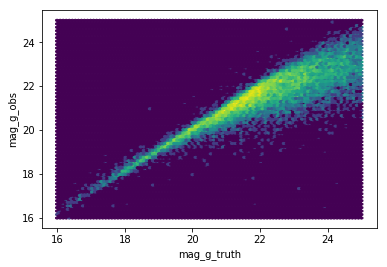

In [12]:
plt.hexbin(truthdata['mag_g'][i0], data['mag_g_cModel'][i1], bins='log', extent=[16, 25, 16, 25])
plt.xlabel('mag_g_truth')
plt.ylabel('mag_g_obs')

Text(0, 0.5, 'mag_g_obs - mag_g_truth')

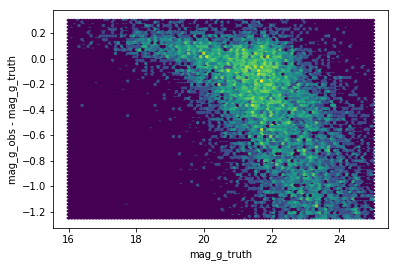

In [13]:
plt.hexbin(truthdata['mag_g'][i0], data['mag_g_cModel'][i1] - truthdata['mag_g'][i0], bins='log', 
           extent=[16, 25, -1.25, 0.3])
plt.xlabel('mag_g_truth')
plt.ylabel('mag_g_obs - mag_g_truth')

### Blendedness
This behavior is not a function of how blended an object is:

Text(0, 0.5, 'mag_g_obs - mag_g_truth')

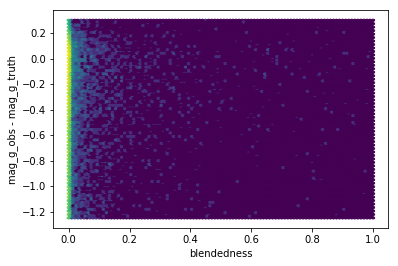

In [25]:
plt.hexbin(data['blendedness'][i0],
           data['mag_g_cModel'][i1] - truthdata['mag_g'][i0],
           bins='log', 
           extent=[0, 1, -1.25, 0.3])
plt.xlabel('blendedness')
plt.ylabel('mag_g_obs - mag_g_truth')

### Isolated Objects
Let's see what the isolated objects look like.  Isolated objects have no parent, so their `parentObjectId == 0`

In [26]:
isolated_centrals = data[i1]['parentObjectId'] == 0

In [27]:
print(f'There are {sum(isolated_centrals)} isolated central galaxies.')

There are 969 isolated central galaxies.


In [28]:
isolated_central_galaxies = data[i1][isolated_centrals]
isolated_central_truth = truthdata[i0][isolated_centrals]

Text(0, 0.5, 'mag_g_obs')

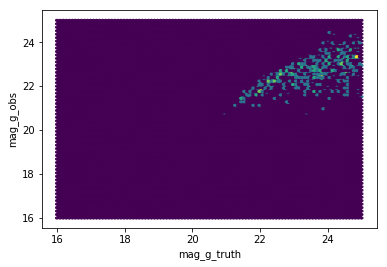

In [29]:
plt.hexbin(isolated_central_truth['mag_g'], isolated_central_galaxies['mag_g_cModel'],
           bins='log', extent=[16, 25, 16, 25])
plt.xlabel('mag_g_truth')
plt.ylabel('mag_g_obs')

Text(0, 0.5, 'mag_g_obs - mag_g_truth')

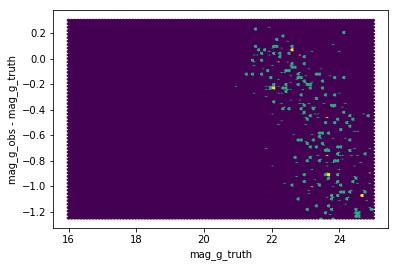

In [30]:
plt.hexbin(isolated_central_truth['mag_g'],
           isolated_central_galaxies['mag_g_cModel'] - isolated_central_truth['mag_g'],
           bins='log',
           extent=[16, 25, -1.25, 0.3])
plt.xlabel('mag_g_truth')
plt.ylabel('mag_g_obs - mag_g_truth')

------
### Metacal magnitudes
Metacal measurements show the same behavior.
There are fewer metacal measurements than the full sample.

Text(0, 0.5, 'mag_g_obs')

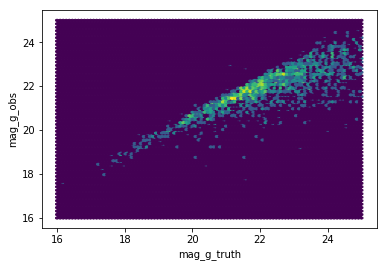

In [31]:
plt.hexbin(truthdata['mag_g'][i0], data['mcal_mag_g'][i1], bins='log', extent=[16, 25, 16, 25])
plt.xlabel('mag_g_truth')
plt.ylabel('mag_g_obs')

Text(0, 0.5, 'mag_g_obs - mag_g_truth')

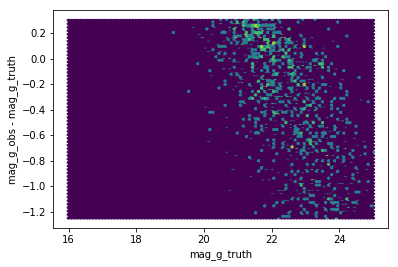

In [32]:
plt.hexbin(truthdata['mag_g'][i0], data['mcal_mag_g'][i1] - truthdata['mag_g'][i0], bins='log', 
           extent=[16, 25, -1.25, 0.3])
plt.xlabel('mag_g_truth')
plt.ylabel('mag_g_obs - mag_g_truth')

------
